# IIR Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
from scipy import signal

np.set_printoptions(precision=16)

In [2]:
def zplane_plot(ax, z, p, k):
    """Plot pole/zero/gain plot of discrete-time, linear-time-invariant system.

    Note that the for-loop handling might be not very efficient
    for very long FIRs

    z...array of zeros in z-plane
    p...array of poles in z-zplane
    k...gain factor

    taken from own work
    URL = ('https://github.com/spatialaudio/signals-and-systems-exercises/'
           'blob/master/sig_sys_tools.py')

    currently we don't use the ax input parameter, we rather just plot
    in hope for getting an appropriate place for it from the calling function
    """
    # draw unit circle
    Nf = 2**7
    Om = np.arange(Nf) * 2*np.pi/Nf
    plt.plot(np.cos(Om), np.sin(Om), 'C7')

    try:  # TBD: check if this pole is compensated by a zero
        circle = Circle((0, 0), radius=np.max(np.abs(p)),
                        color='C7', alpha=0.15)
        plt.gcf().gca().add_artist(circle)
    except ValueError:
        print('no pole at all, ROC is whole z-plane')

    zu, zc = np.unique(z, return_counts=True)  # find and count unique zeros
    for zui, zci in zip(zu, zc):  # plot them individually
        plt.plot(np.real(zui), np.imag(zui), ms=8,
                 color='C0', marker='o', fillstyle='none')
        if zci > 1:  # if multiple zeros exist then indicate the count
            plt.text(np.real(zui), np.imag(zui), zci)

    pu, pc = np.unique(p, return_counts=True)  # find and count unique poles
    for pui, pci in zip(pu, pc):  # plot them individually
        plt.plot(np.real(pui), np.imag(pui), ms=8,
                 color='C0', marker='x')
        if pci > 1:  # if multiple poles exist then indicate the count
            plt.text(np.real(pui), np.imag(pui), pci)

    plt.text(0, +1, 'k={0:f}'.format(k))
    plt.text(0, -1, 'ROC for causal: white')
    plt.axis('square')
    plt.xlabel(r'$\Re\{z\}$')
    plt.ylabel(r'$\Im\{z\}$')
    plt.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')


def bode_plot(b, a, N=2**10, fig=None):  # for IIR if length of b and a are the same
    if fig is None:
        fig = plt.figure()

    z, p, gain = signal.tf2zpk(b, a)
    W, Hd = signal.freqz(b, a, N, whole=True)

    # print('number of poles:', len(p), '\npole(s) at:', p,
    #      '\nnumber of zeros:', len(z), '\nzero(s) at:', z)

    gs = fig.add_gridspec(2, 2)
    # magnitude
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(W/np.pi, np.abs(Hd), "C0",
             label=r'$|H(\Omega)|$)',
             linewidth=2)
    ax1.set_xlim(0, 2)
    ax1.set_xticks(np.arange(0, 9)/4)
    ax1.set_xlabel(r'$\Omega \,/\, \pi$', color='k')
    ax1.set_ylabel(r'$|H|$', color='k')
    ax1.set_title("Magnitude response", color='k')
    ax1.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')

    # phase
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(W/np.pi, (np.angle(Hd)*180/np.pi), "C0",
             label=r'$\mathrm{angle}(H('r'\omega))$',
             linewidth=2)
    ax2.set_xlim(0, 2)
    ax2.set_xticks(np.arange(0, 9)/4)
    ax2.set_xlabel(r'$\Omega \,/\, \pi$', color='k')
    ax2.set_ylabel(r'$\angle(H)$ / deg', color='k')
    ax2.set_title("Phase response", color='k')
    ax2.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')

    # zplane
    ax3 = fig.add_subplot(gs[0, 1])
    zplane_plot(ax3, z, p, gain)

    # impulse response
    N = 2**4  # here specially chosen for the examples below
    k = np.arange(0, N)
    x = np.zeros(N)
    x[0] = 1
    h = signal.lfilter(b, a, x)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.stem(k, h, linefmt='C0', markerfmt='C0o',
             basefmt='C0:')
    ax4.set_xlabel(r'$k$')
    ax4.set_ylabel(r'$h[k]$')
    ax4.set_title('Impulse Response')
    ax4.grid(True, which="both", axis="both", linestyle="-",
             linewidth=0.5, color='C7')


# some defaults for the upcoming code:
figsize = (12, 9)

In [3]:
# taken from lecture's repository
# https://github.com/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/audiofilter.py


def bilinear_biquad(B, A, fs):
    """Get the bilinear transform of a 2nd-order Laplace transform.

    bilinear transform H(s)->H(z) with s=2*fs*(z-1)/(z+1)

    input:
    B[0] = B0   B[1] = B1   B[2] = B2
    A[0] = A0   A[1] = A1   A[2] = A2
    fs...sampling frequency in Hz
           Y(s)   B0*s^2+B1*s+B2   B[0]*s^2+B[1]*s+B[2]
    H(s) = ---- = -------------- = --------------------
           X(s)   A0*s^2+A1*s+A2   A[0]*s^2+A[1]*s+A[2]
    output:
    b[0] = b0   b[1] = b1   b[2] = b2
    a[0] = 1    a[1] = a1   a[2] = a2
           Y(z)   b2*z^-2+b1*z^-1+b0   b[2]*z^-2+b[1]*z^-1+b[0]
    H(z) = ---- = ------------------ = ------------------------
           X(z)   a2*z^-2+a1*z^-1+ 1   a[2]*z^-2+a[1]*z^-1+a[0]
    """
    A0, A1, A2 = A
    B0, B1, B2 = B
    fs2 = fs**2

    a0 = 1
    b0 = 1

    b1 = 1
    a1 = 0.5

    b2 = 2
    a2 = 0.1

    b = np.array([b0, b1, b2]) / a0
    a = np.array([a0, a1, a2]) / a0

    return b, a


def f_prewarping(f, fs):
    """Do the frequency prewarping for bilinear transform.

    input:
    f...analog frequency in Hz to be prewarped
    fs...sampling frequency in Hz
    output:
    prewarped angular frequency wpre in rad/s
    """
    return 2*fs*np.tan(np.pi*f/fs)

# Filter Fundamentals

The transfer function of digital filters can be generally expressed in the $z$-domain as
\begin{equation}
H(z)=\frac{Y(z)}{X(z)} = \frac{\sum\limits_{m=0}^M b_mz^{-m}}{\sum\limits_{n=0}^N a_nz^{-n}}
=\frac{b_0z^0+b_1z^{-1}+b_2z^{-2}+...+b_Mz^{-M}}{a_0z^0+a_1z^{-1}+a_2z^{-2}+...+a_Nz^{-N}}
\end{equation}
with input $X(z)$ and output $Y(z)$.
Real input signals $x[k]$ that should end up as real output signals $y[k]$ (in terms of signal processing fundamentals this is a special case, though most often needed in practice) require real coefficients $b,a\in\mathbb{R}$.
This is only achieved with

- single or multiple **real** valued
- single or multiple **complex conjugate** pairs

of zeros and poles.

Furthermore, in practice we most often aim at (i) causal and (ii) bounded input, bound output (BIBO) stable LTI systems, which requires (i) $M \leq N$ and (ii) poles inside the unit circle.
If all poles **and** zeros are **inside** the unit circle then the system is **minimum-phase** and thus $H(z)$ is straightforwardly **invertible**.

Further concepts related to the transfer function are:

- Analysis of the transfer characteristics is done by the DTFT
$H(z=\mathrm{e}^{\mathrm{j}\Omega})$, i.e. evaluation on the unit circle.

- We use $a_0=1$ according to convention in many textbooks.

- The convention for arraying filter coefficients is straightforward with Python index starting at zero:
$b_0=b[0]$, $b_1=b[1]$, $b_2=b[2]$, ..., $a_0=a[0]=1$, $a_1=a[1]$, $a_2=a[2]$.

## Filtering Process

- A **non-recursive** system with $a_1,a_2,...,a_N=0$ always exhibits a **finite
impulse response** (FIR), note: $a_0=1$ for output though. Due to the finite length impulse response, a non-recursive system is always stable.

- The output signal of a **non-recursive** system in practice can be calculated by **linear
convolution** 
\begin{equation}
y[k] = \sum\limits_{m=0}^{M} h[m] x[-m+k]
\end{equation}
of the finite impulse response $h[m]=[b_0, b_1, b_2,...,b_M]$ and the input signal $x[k]$.

- A **recursive system** exhibits at least one $a_{n\geq1}\neq0$. Because
of the feedback of the output into the system, a potentially **infinite impulse
response** (IIR) and a potentially non-stable system results.

- For a **recursive** system, in practice the **difference equation**
\begin{equation}
y[k] = b_0 x[k] + b_1 x[k-1] + b_2 x[k-2] + ... + b_M x[k-M] -a_1 y[k-1] - a_2 y[k-2] - a_3 y[k-3] - ... - a_N y[k-N]
\end{equation}
needs to be implemented.

- A **pure non-recursive** system is obtained by ignoring the feedback paths, i.e. setting $a_1,a_2,...,a_N=0$.
- A **pure recursive** system is obtained by ignoring the forward paths, i.e. setting $b_0,b_1,...,b_M=0$. Then, the values of the state variables $z^{-1}, z^{-2}, ..., z^{-M}$ alone determine how the system starts to perform at $k=0$, since the system has no input actually. This system type can be used to generate (damped) oscillations.

Please note: A recursive system can have a finite impulse response, but this is very rarely the case.
Therefore, literature usually refers to
- an FIR filter when dealing with a non-recursive system
- an IIR filter when dealing with a recursive system

## Signal Flow Chart of Direct Form I

For example, the signal flow for a **second order** ($M=N=2$), system with
- a non-recursive part (feedforward paths, left $z^{-}$-path)
- a recursive part (feedback paths, left $z^{-}$-path)

is depicted below (graph taken from Wikimedia Commons) as straightforward **direct form I**, i.e. directly following the difference equation.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Biquad_filter_DF-I.svg" width=500>

Such a second order section is usually termed a biquad.

# IIR Filter

In the following 2nd order IIR filters shall be discussed.
The transfer function is with usual convention $a_0=1$

\begin{equation}
H(z)=\frac{\sum\limits_{m=0}^2 b_mz^{-m}}{\sum\limits_{n=0}^2 a_nz^{-n}}
=\frac{b_0+b_1z^{-1}+b_2z^{-2}}{1+a_1z^{-1}+a_2z^{-2}}
\end{equation}

Very simple pole / zero placements are given in order to demonstrate the principle and the impact of zeros and poles.
Once this is understood, more complicated filter characteristics and filter design methods can be approached.

## Pole Zero Placement Examples for IIR Filters of 2nd Order

Let us define a small function where we can define a complex zero $z_0 = z_r \mathrm{e}^{\mathrm{j} z_a}$ and a complex pole $p_0 = p_r \mathrm{e}^{\mathrm{j} p_a}$ and the function finds the complex conjugates, the IIR filter coefficients $b$ and $a$ and plots magnitude, phase response, pole/zero map and impulse response.

In [4]:
def pz_placement(zr, za, pr, pa):
    z = zr * np.exp(+1j*za)
    p = pr * np.exp(+1j*pa)

    b = [1,1,2]
    a = [1,0.5,0.1]

    bode_plot(b, a, fig=plt.figure(figsize=figsize))

Then we can play around with some pole/zero alignments.

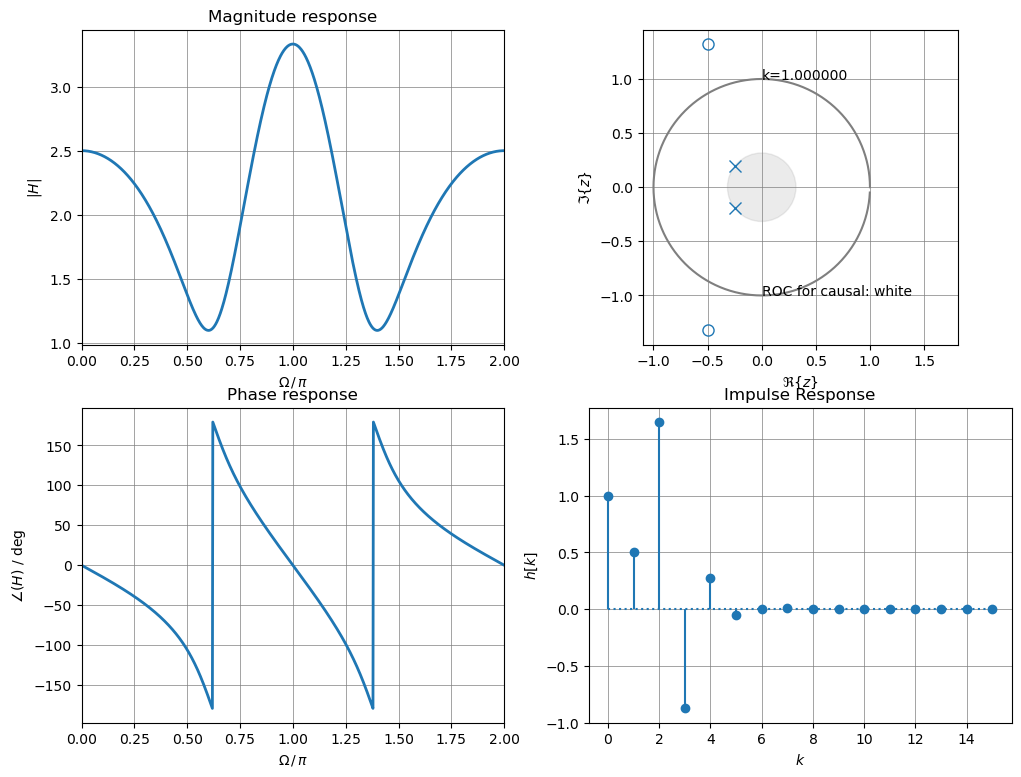

In [5]:
# no IIR actually, but rather FIR just to make a point:
# put poles into origin
pz_placement(zr=1/2, za=np.pi/2, pr=0, pa=0)

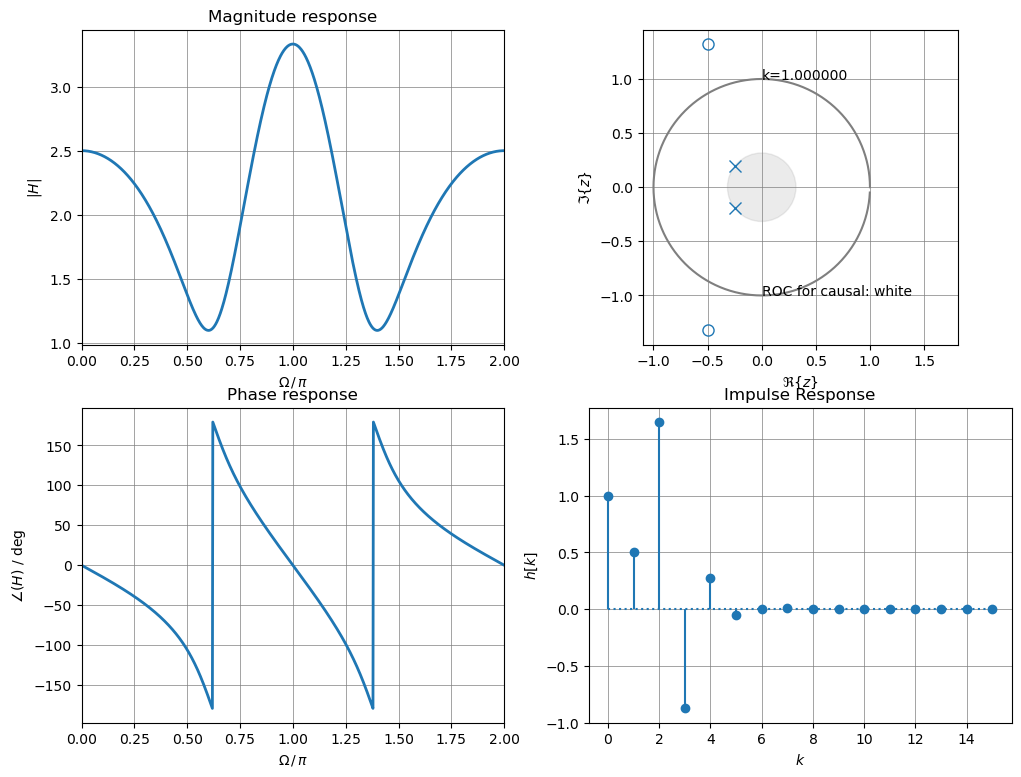

In [6]:
# filter transfer function from above can be inverted
# this yields a stable IIR filter, since its poles are inside unit circle
# and thus white ROC includes the unit cirlce
pz_placement(zr=0, za=0, pr=1/2, pa=np.pi/2)

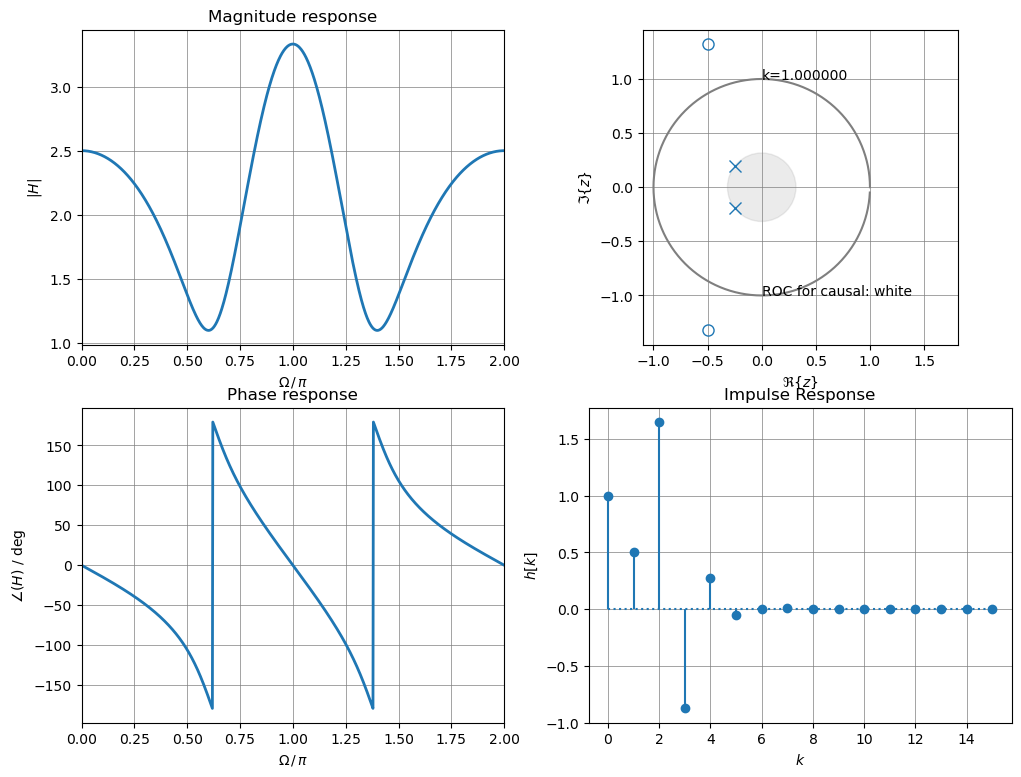

In [7]:
# shift zeros closer to poles
# less ripple in magnitude response
# note that y-axis has changed in comparison to above example
pz_placement(zr=1/3, za=np.pi/2, pr=1/2, pa=np.pi/2)

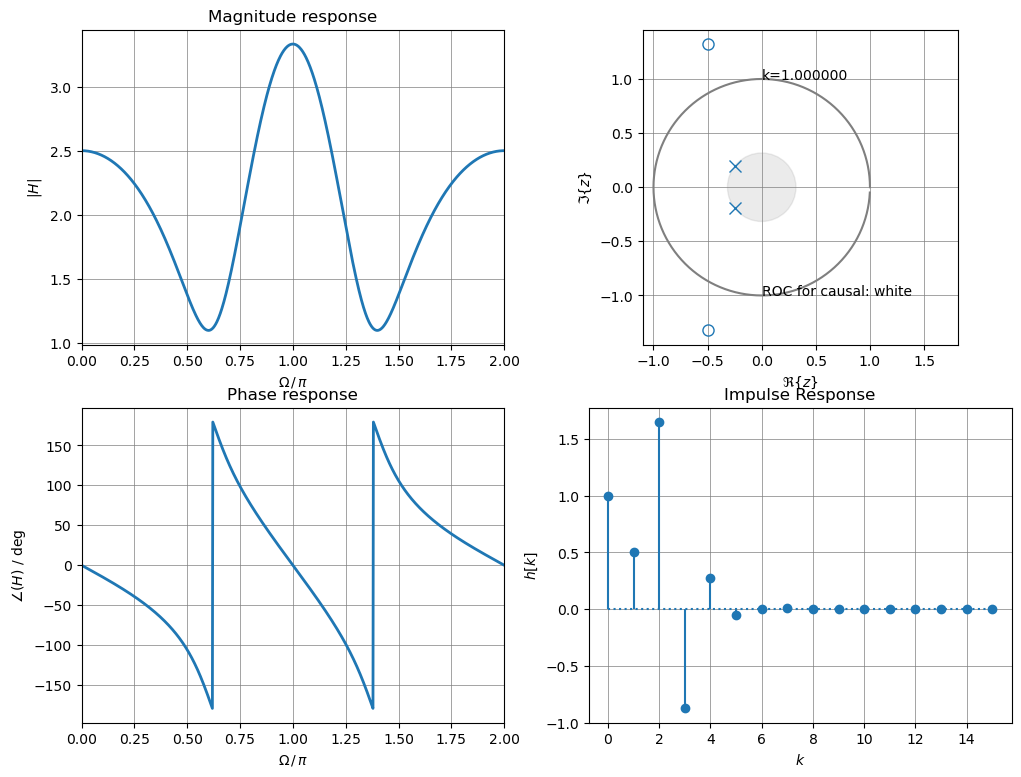

In [8]:
# 2nd order lowpass filter
# special here is:
# zero at -1 thus amplitude 0 at fs/2, phase -180 deg at fs/2
# two real poles at same location
pz_placement(zr=1, za=np.pi, pr=1/2, pa=0)

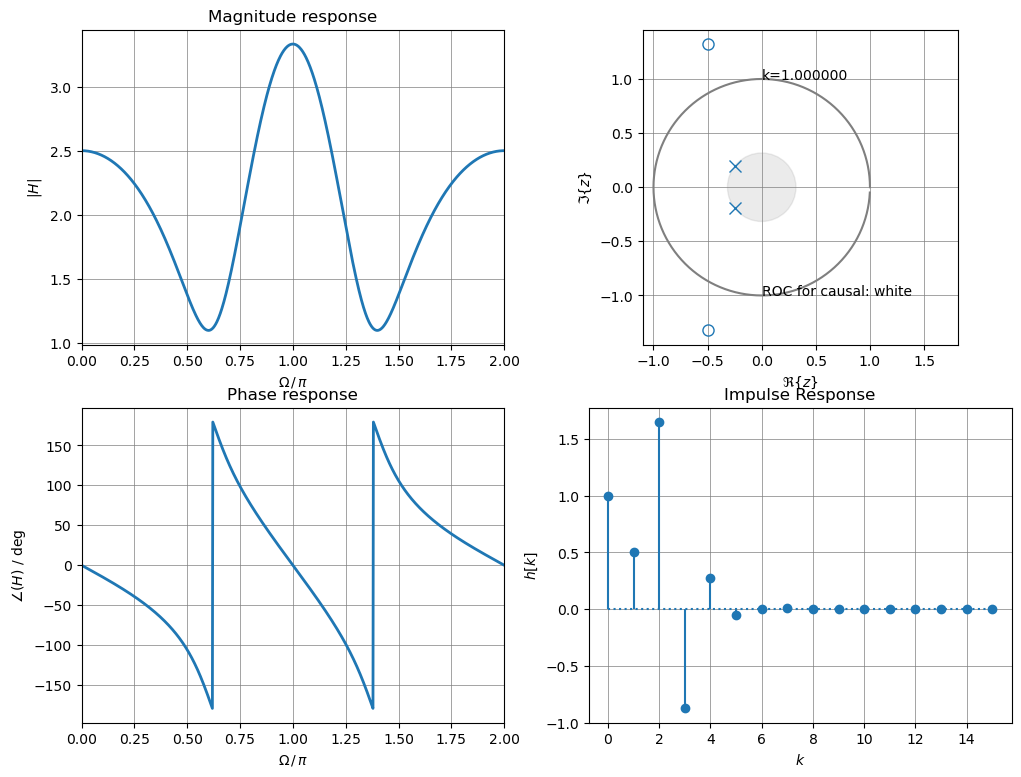

In [9]:
# 2nd order lowpass filter
# zero at -1 thus amplitude 0 at fs/2
# this time complex conjugate pole pair to yield about the same magnitude
# at DC
# check the differences between the two filters
# you might create an own plot where both filters can be overlayed 
pz_placement(zr=1, za=np.pi, pr=3/5, pa=np.pi/8)